<h1 id='title'>Hyperion</h1>

**Author:** José Verdú Díaz

**Contact:** jose.verdu-diaz2@newcastle.ac.uk

**Date:** 16/02/2022

<div id="index_div">
<ul>
<li><a href='#load'>Load</a></li>
<li><a href='#preprocess'>Preprocess</a></li>
</ul>
</div>

---

<a id='load'></a>

## Load Modules and Data

In [7]:
import json
import tifffile as tf
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns

%matplotlib inline
sns.set_style("white")

Function for loading hyperion multi-image tiff files. Returns all image slices, an array of channels and an array of labels.

In [2]:
def parse_tiff(tiff_path, summary_path):
    tiff_slices = tf.TiffFile(tiff_path).asarray()
    metals, labels = [], []

    summary_df = pd.read_csv(summary_path, sep = '\t')

    for slice in range(tiff_slices.shape[0]):
        metals.append(str(summary_df['Channel'][slice]))
        labels.append(str(summary_df['Label'][slice]))

    return((tiff_slices,metals,labels))

Load example tiff.

In [3]:
images,metals,labels = parse_tiff('../input/ROI001_ROI_001.ome.tiff', '../input/ROI001_ROI_001_summary.txt')

---

<a id='preprocess'></a>

## Preprocess

Select an example slice:

In [10]:
slice = 23

img = np.flipud(images[slice]) # Flip to correct rotation
metal = metals[slice]
label = labels[slice]

Normalize all pixel values inside the range (0,1). Pixels divided by a maximum quantile to avoid high-valued artifacts reducing the overall contrast of the image. Note that this will produce <a href='https://en.wikipedia.org/wiki/Clipping_(signal_processing)'>clipping</a> (undesired) of higher values. A value of top_quantile has to be chosen in order to reduce clipping while reducing the effect of artifacts.

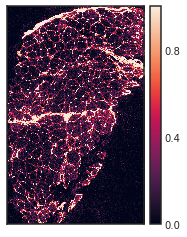

In [14]:
top_quantile = 0.95
img_normalized = np.minimum(img / np.quantile(img, top_quantile), 1.0)

image_used = img_normalized

isns.imgplot(image_used, height=30);

#Image.fromarray(np.array(np.round(255.0 * img_normalized), dtype=np.uint8)).save('../output/img.jpg', quality=100)


In [ ]:
def makeMask(size,tuples):
    black = Image.new('1', size)
    imd = ImageDraw.Draw(black)
    imd.polygon(tuples,fill="white",outline="white")
    return(np.array(black))

with open('../input/H7711_1ann.geojson') as f: annotation_data = json.load(f)

n_annotations = len(annotation_data["features"])

blob = annotation_data["features"][0]["geometry"]

if blob["type"] == "LineString": coords = blob["coordinates"]
if blob["type"] == "Polygon": coords = blob["coordinates"][0]

tuples = [tuple(coord) for coord in coords]

In [ ]:
img_size = Image.fromarray(img).size

mask = makeMask(img_size, tuples)

%matplotlib inline

plt.imshow(mask)
plt.show()

In [ ]:
maskp = np.logical_and(mask,image_used > 0.5)

%matplotlib inline

plt.figure(figsize=(20, 20))
plt.imshow(maskp)
plt.show()

In [ ]:
nonzeros = image_used[maskp]
allpix = image_used[mask]

mean = np.mean(nonzeros)
median = np.median(nonzeros)

mean_all = np.mean(allpix)
median_all = np.median(allpix)

area = np.sum(mask)
posarea = np.sum(maskp)

posfrac = float(posarea)/float(area)

summ = {
    "label": [label],
    "area": [area],
    "mean_pos" : [mean],
    "median_pos" : [median],
    "mean_all" : [mean_all],
    "median_all" : [median_all],
    "pos_area" : [posarea],
    "pos_fraction" : [posfrac]
}

df = pd.DataFrame.from_dict(summ)

df

In [ ]:
isns.imghist(np.flipud(img_normalized), bins=100, describe=True, height=20, cmap = 'viridis')